In [1]:
import os
import json
from tqdm import tqdm_notebook
import time
import numpy as np
import scipy
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
# Для обработки текстов
import pymorphy2

In [4]:
# Для работы с нейросетями
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

Загрузите данные

Создайте папку и положите в неё данные (avito_train.csv и avito_category.csv). Путь к папке назвать DIR_PATH

In [5]:
DIR_PATH='data/'

In [6]:
dat = pd.read_csv(os.path.join(DIR_PATH, 'avito_train.csv'))
cat_descr = pd.read_csv(os.path.join(DIR_PATH, 'avito_category.csv'))
dat['category_name'] = dat.category_id.map(dict(zip(cat_descr.category_id, cat_descr.name)))

In [7]:
dat.head()

,item_id,title,description,price,category_id,category_name
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки


### Задание 1
### Подготовка данных

[1.1] (0.5 балла)

Разбейте таргет на иерархические классы.

In [8]:
# Проверяем, что нет каких-то нешаблонных категорий
dat.category_name.apply(lambda x: x[:x.find('|')]).value_counts()

Для дома и дачи        139494
Бытовая электроника    131350
Хобби и отдых          111374
Личные вещи            107299
Name: category_name, dtype: int64

In [9]:
# Ваш код здесь:
dat['category_1'] = dat.category_name.apply(lambda x: int(x[0] == 'Д')) # для дома
dat['category_2'] = dat.category_name.apply(lambda x: int(x[0] == 'Л')) # личные вещи
dat['category_3'] = dat.category_name.apply(lambda x: int(x[0] == 'Х')) # хобби и отдых
dat['category_4'] = dat.category_name.apply(lambda x: int(x[0] == 'Б')) # бытовая электроника

Загрузите список стоп-слов https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json

In [10]:
# Ваш код здесь:
stop_words = pd.read_json('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json')
stop_words = np.ravel(stop_words)
stop_words[:5]

array(['c', 'а', 'алло', 'без', 'белый'], dtype=object)

[1.2] (1 балл)

Лемматизируйте категории (таргеты)

In [11]:
morph = pymorphy2.MorphAnalyzer()

In [12]:
# Ваш код здесь:
dat['category_name_processed'] = dat.category_name.apply(lambda x: morph.parse(x)[0].normal_form)

[1.3] (2 балла)

Лемматизируйте заголовки и описания объявлений

In [13]:
# Ваш код здесь:
dat['title_processed'] = dat.title.apply(lambda x: morph.parse(x)[0].normal_form)
dat['description_processed'] = dat.description.apply(lambda x: morph.parse(x)[0].normal_form)

[1.4] (0.5 балла)

Разбейте данные на обучение, валидацию и отложенный тест в пропорции 60/30/10. Постройте распределений категорий в каждом из разбиений для того, чтобы убедиться, что распределения совпадают

In [14]:
# Ваш код здесь:
np.random.seed(10) # Не меняем random seed!
tr_indexes, val_indexes, te_indexes = np.split(
    np.random.permutation(np.arange(489517)), [int(489517*0.6), int(489517*0.9)]
)

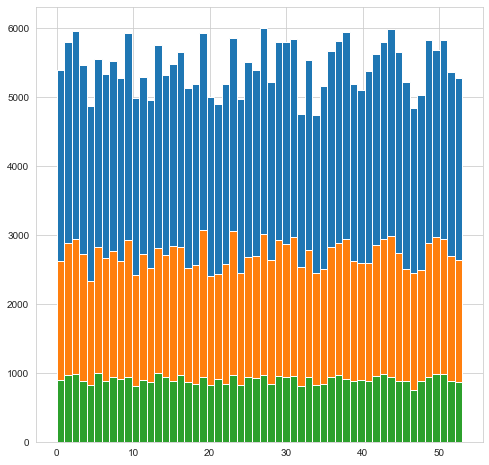

In [15]:
# Здесь постройте распределения:
factorize, keys = dat.category_name.factorize()

for inds in [tr_indexes, val_indexes, te_indexes]:
    pd.Series(factorize[inds]).hist(bins=len(keys))

#### Видим, что распределения абсолютно идентичны, так что тестирование будет "честным".

### Задание 2
### Бейзлайн

[2.1] (5 баллов)

Обучите простую модель для того, чтобы в дальнейшем с ней сравниваться. Точность (accuracy) данной бейзлан модели должна быть > 0.6. 

В качестве такой модели можно взять Tf-Idf преобразования текстов + (logreg/random forest/boosting/...). Можно так же попробовать в качестве признаков взять word2vec вектора слов.

In [16]:
# Ваш код здесь:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X = (dat['title_processed'] + ' ' + dat['description_processed']).values
price = dat['price'].values

ppl = Pipeline([
    ('bag_of_words', CountVectorizer(stop_words=list(stop_words), min_df=5)),
    ('tf_idf', TfidfTransformer()),
    ('log_reg', LogisticRegression())
])

ppl.fit(X[tr_indexes], factorize[tr_indexes])

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('bag_of_words',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['c', 'а', 'алло', 'без', 'белый',
                                             'близко', 'более', 'больше',
                                             'большой', 'будем', 'буде...
                                 tokenizer=None, vocabulary=None)),
                ('tf_idf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_we

In [17]:
model = LogisticRegression()
X_train_model = np.hstack((ppl.predict_proba(X[tr_indexes]), price[tr_indexes][:, None]))
model.fit(X_train_model, factorize[tr_indexes])

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

[2.2] (2 балла)

Посчитайте качество вашей бейзлайн модели на отложенном тесте (te_indexe)

In [18]:
# Ваш код здесь:
inds = te_indexes

X_test_model = np.hstack((ppl.predict_proba(X[inds]), price[inds][:, None]))
preds = model.predict(X_test_model)
print(f'Accuracy: {accuracy_score(factorize[inds], preds)}')
print(f'F_measure: {f1_score(factorize[inds], preds, average="macro")}')

Accuracy: 0.8615786893283216
F_measure: 0.8572563430035928


### Посмотрим также на качество на валидации

In [19]:
inds = val_indexes

X_val_model = np.hstack((ppl.predict_proba(X[inds]), price[inds][:, None]))
preds = model.predict(X_val_model)
print(f'Accuracy: {accuracy_score(factorize[inds], preds)}')
print(f'F_measure: {f1_score(factorize[inds], preds, average="macro")}')

Accuracy: 0.8615505090054816
F_measure: 0.8580386197300792


### Задание 3

### Нейросетки

Настало время для действительно крутых моделей!

[3.1] (26 баллов) [Точность на тесте 0.6 - 0 баллов, точность на тесте 0.86 и более - 26 баллов]

Обучите нейросетку, которая бы решала данную задачу с точностью > 0.86. Вы неограничены в выборе архитектуры нейросети. Можно начать с Tf-Idf + полносвязная сеть. Экспериментируйте!

In [17]:
import time
from sklearn.decomposition import TruncatedSVD

n_features = 4000

tf_idf = TfidfVectorizer(stop_words=list(stop_words), min_df=40)
X_train = tf_idf.fit_transform(X[tr_indexes])
X_val = tf_idf.transform(X[val_indexes])
X_test = tf_idf.transform(X[te_indexes])

svd = TruncatedSVD(n_features)
X_train = svd.fit_transform(X_train)
X_val = svd.transform(X_val)
X_test = svd.transform(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [22]:
n_hidden = int((n_features+1) * len(keys)**(1/2))
model = nn.Sequential(
    nn.Linear(n_features, n_hidden),
    nn.Dropout(0.1),
    nn.Linear(n_hidden, len(keys)),
    nn.Sigmoid()
)

opt = optim.Adamax(model.parameters(), lr=0.009)
num_epochs = 3
batch_size = 1024

train_loss = []
val_accuracy = []

In [23]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]
        
def compute_loss(X_batch, y_batch):
    X_batch = torch.autograd.Variable(torch.FloatTensor(X_batch))
    y_batch = torch.autograd.Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return nn.functional.cross_entropy(logits, y_batch).mean()

In [24]:
y_train, y_val, y_test = factorize[tr_indexes], factorize[val_indexes], factorize[te_indexes]

In [26]:
for epoch in range(num_epochs):

    start_time = time.time()
    model.train(True) 
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.autograd.Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    print("Эпоха {} из {} заняла {:.3f} секунд".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  Ошибка на трейне: {:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  Точность на валидации: {:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Эпоха 1 из 3 заняла 645.187 секунд
  Ошибка на трейне: 3.1144517
  Точность на валидации: 82.31 %
Эпоха 2 из 3 заняла 544.806 секунд
  Ошибка на трейне: 3.102087
  Точность на валидации: 85.41 %
Эпоха 3 из 3 заняла 589.723 секунд
  Ошибка на трейне: 3.089121
  Точность на валидации: 87.27 %


### Оцениваем качество на тесте

In [52]:
preds = np.argmax(model(torch.autograd.Variable(torch.FloatTensor(X_test))), axis=1)
print(f'Accuracy: {accuracy_score(factorize[inds], preds)}')
print(f'F_measure: {f1_score(factorize[inds], preds, average="macro")}')

Accuracy: 0.883722830527864
F_measure: 0.8814360087807735


### И это при том, что мы никак не использовали в нейронке данные о цене!